# Basic tutorial on how to use the module `basilpy`

In [328]:
import basilpy as bs

We import some standard pyhton modules

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=25)

## 1. Ignoring the signal/background likelihoods

The most import class of `basilpy` is

`OnOffMeasurement`

This class allows you to handle ON/OFF measurments and estimated the signal

Let's see one example.

For now we will ingore the likelihoods for each event of being a signal or background, so we will get the signla PDF from simply coinsidering the observed counts in the ON region $N_{on}$, in the OFF region $N_{off}$ and the normalization factor $\alpha$

In [59]:
Non   = 22
Noff  = 50
alpha = 0.2
m1    = bs.OnOffMeasurement( Non, Noff, alpha)

In [60]:
print(m1)

OnOffMeasurement
----------------

  Non                             :  22 
  Noff                            :  50 
  Alpha                           :  0.2 

  Excess                          :  12.0 
  SD Excess                       :  4.898979485566356 
  Li&Ma Significance              :  2.9047925360855653 




The object `m1` is an ON/OFF measurement from which we can already get some information on the excess and its significance computed with the standard Li&Ma formula

With the function `run` we can now compute the PMF of the number of signal events and the signal PDF, just assuming the Poissonian nature of the signal and the background (and no systematic errors)

In [61]:
%%time
m1.run()

CPU times: user 260 ms, sys: 16.7 ms, total: 277 ms
Wall time: 262 ms


In [62]:
print(m1)

OnOffMeasurement
----------------

  Non                             :  22 
  Noff                            :  50 
  Alpha                           :  0.2 

  Excess                          :  12.0 
  SD Excess                       :  4.898979485566356 
  Li&Ma Significance              :  2.9047925360855653 

  Most probable signal            :  11.90164303092625 
  Expected signal                 :  12.818218456199075 
  Signal SD                       :  3.5802539653213254 



Did you notice?

The most probable signal is different from the excess, which is also different from the expected signal

This is because the PDF of the signal is not simmetric (negative values do not make any sense)

We can plot the PDF and the PMF as shown below

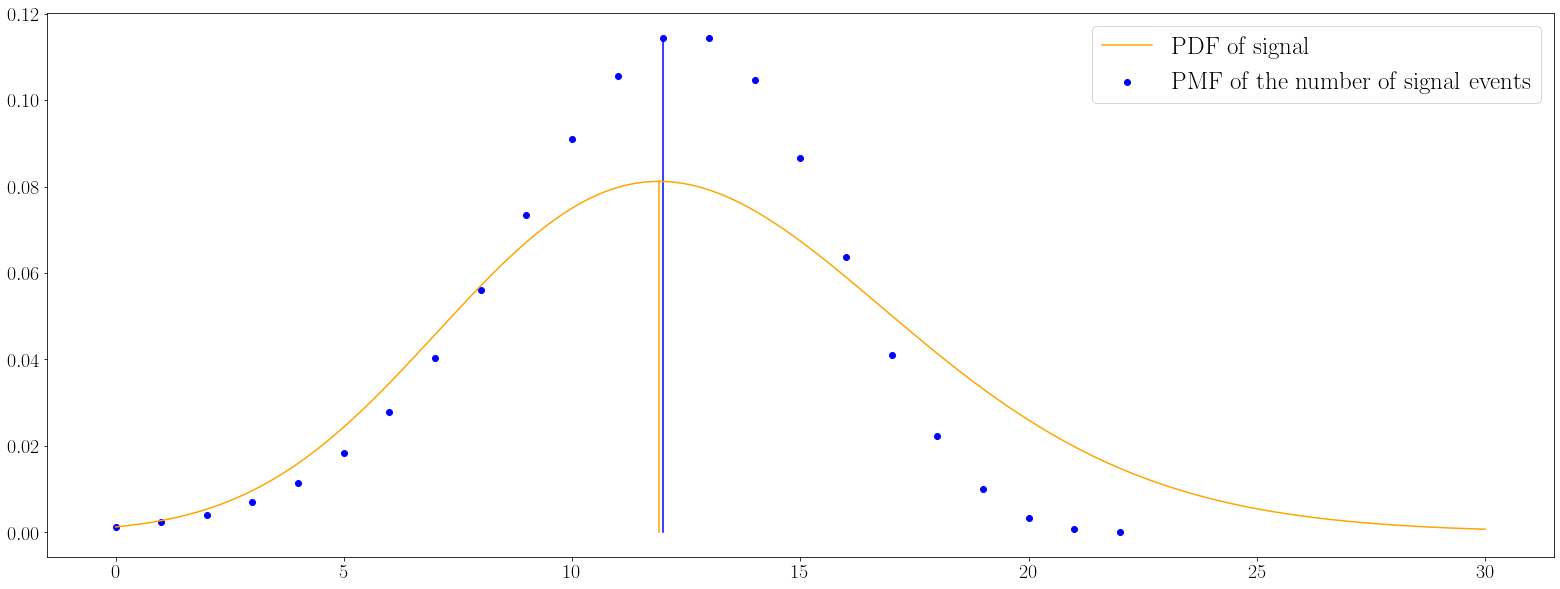

In [63]:
fig, ax = plt.subplots(figsize=(27,10),nrows=1, ncols=1)
# PLOT PMF
ax.scatter( m1.Ns, m1.pmf, label = "PMF of the number of signal events", c="blue")
ax.plot( (m1.mode_pmf,m1.mode_pmf), (0,m1.pmf[m1.Ns==m1.mode_pmf][0]), c="blue")
# PLOT PDF
s = np.linspace(0,30,1000)
ax.plot( s, m1.pdf(s), label = "PDF of signal", c="orange" )
ax.plot( (m1.mode_pdf,m1.mode_pdf), (0,m1.pdf(m1.mode_pdf)), c="orange")

ax.legend()

We can now compute the 95% upeer limit (UL) ...

In [64]:
%%time
UL = m1.upper_limit( 0.95 )
UL

CPU times: user 57.1 ms, sys: 3.14 ms, total: 60.2 ms
Wall time: 59.2 ms


21.510562474446274

... or the 68% credible interval (CI) to not be confused with the frequentist confidence interval

In [65]:
%%time
CI_low, CI_up = m1.credible_interval() # by default CI at 68.27%
CI_low, CI_up 

CPU times: user 3.3 s, sys: 12.4 ms, total: 3.31 s
Wall time: 3.31 s


(7.2588843228967, 17.100166862070044)

Below a visualization of the UL and CI just computed

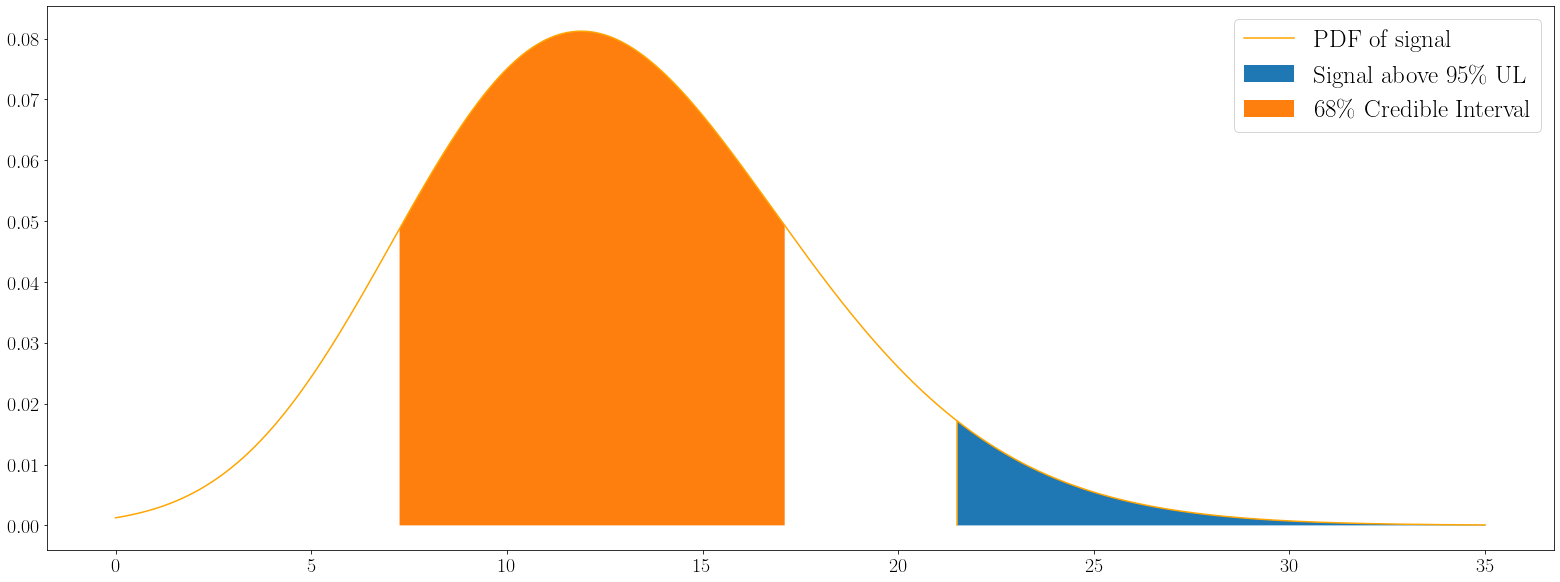

In [66]:
fig, ax = plt.subplots(figsize=(27,10),nrows=1, ncols=1)
# PLOT PDF
s = np.linspace(0,35,1000)
ax.plot( s, m1.pdf(s), label = "PDF of signal", c="orange" )
ax.plot( (UL,UL), (0,m1.pdf(UL)), c="orange")
#SHOW UL
x = np.linspace(UL,35,1000)
y = m1.pdf(x)
ax.fill_between(x,y, label="Signal above 95\% UL")
#SHOW CI
x = np.linspace(CI_low,CI_up,1000)
y = m1.pdf(x)
ax.fill_between(x,y, label="68\% Credible Interval")

ax.legend()

## 2. Including the signal/background likelihoods

We now want to include the information about the **likelihood** of being a signal or background event of each single event

For this purpose we define a *Toy Model* in which we have observed for each event a discrimintaing variable `x` which can take values between 0 and 1

Observations of `x` from a **signal population** are distribuited as

$$
N \frac{1}{(a+x)^2}
$$

with $N = a(1+a)$ a normalization factor.

Observations of `x` from a **background population** have instead a unifrom distribution

We will use the Class `PDF` available in `basilpy`

The Class `PDF` allows you to define from any custom function (which is defined positive in a given range) a `pdf`, its `cdf`, the inverse of the cdf `invcdf` and a function `fake` that generates random variables according to the custom pdf

We we first construct the `bkg_pdf`

In [67]:
bkg_func    = lambda x: np.ones_like(x)
bkg_pdf    = bs.PDF(bkg_func)

below its visualization

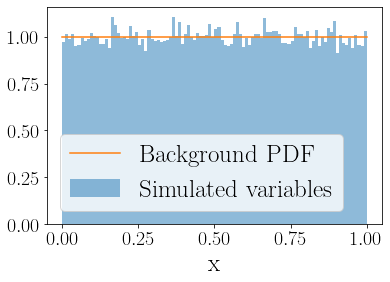

In [68]:
x = bkg_pdf.fake(50000)
plt.hist(x, alpha=0.5, density=True,bins=100, label="Simulated variables")
#
t = np.linspace(0,1,1000)
plt.plot(t, bkg_pdf(t),label="Background PDF")
plt.xlabel("x")
plt.legend()

Then the `signal_pdf`  ( you can play with the values of $a$ )

In [69]:
a           = 0.2
signal_func = lambda x: 1/(a+x)**2
signal_pdf = bs.PDF(signal_func)

below its visualization

Text(0.5, 0, 'x')

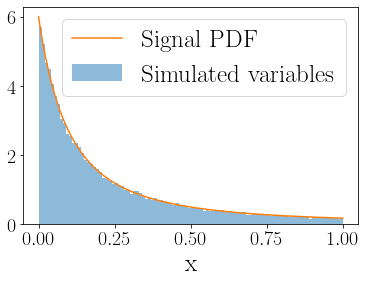

In [71]:
x = signal_pdf.fake(50000)
plt.hist(x, alpha=0.5, density=True,bins=100, label="Simulated variables")
#
t = np.linspace(0,1,1000)
plt.plot(t, signal_pdf(t),label="Signal PDF")
plt.legend()
plt.xlabel("x")

It is now time to generate the `observed_x`, i.e. the observed values of `x` for each of the $N_{on}$ event

Feel free to change how to get `observed_x`. Below for instance we will assume that all events come from a signal poulation

In [73]:
observed_x = signal_pdf.fake( Non  )

We can now compute from the `observed_x` the likelihood for each event of being a signal or background

In [74]:
bkg_likelihoods    = bkg_pdf(observed_x)
signal_likelihoods = signal_pdf(observed_x)

We now create again a new Class `OnOffMeasurement` but notice that this time we give in input the background and signal likelihoods computed before

Notice that `Non`, `Noff` and `alpha` are the same used for `m1`

In [75]:
Non   = 22
Noff  = 50
alpha = 0.2

m2    = bs.OnOffMeasurement( Non, Noff, alpha,
                           bkg_likelihoods    = bkg_likelihoods,
                           signal_likelihoods = signal_likelihoods)
print(m2)

OnOffMeasurement
----------------

  Non                             :  22 
  Noff                            :  50 
  Alpha                           :  0.2 

  Excess                          :  12.0 
  SD Excess                       :  4.898979485566356 
  Li&Ma Significance              :  2.9047925360855653 




We run the pdf computation with `run`

In [76]:
%%time
m2.run()

CPU times: user 246 ms, sys: 15.5 ms, total: 262 ms
Wall time: 247 ms


In [77]:
print(m2)

OnOffMeasurement
----------------

  Non                             :  22 
  Noff                            :  50 
  Alpha                           :  0.2 

  Excess                          :  12.0 
  SD Excess                       :  4.898979485566356 
  Li&Ma Significance              :  2.9047925360855653 

  Most probable signal            :  16.702288462711977 
  Expected signal                 :  17.712436401821034 
  Signal SD                       :  4.208614546596188 



Did you notice?

The most probable signal is bigger than the excess simply computed from $N_{on} - \alpha N_{off}$.

That's because in the computation of the signal PDF we have included the events likleihoods, which were obtanained from the assumption that all ON events are likely to be signal events

We can visualize this with the plot below, where a comparison between `m1` and `m2` is shown

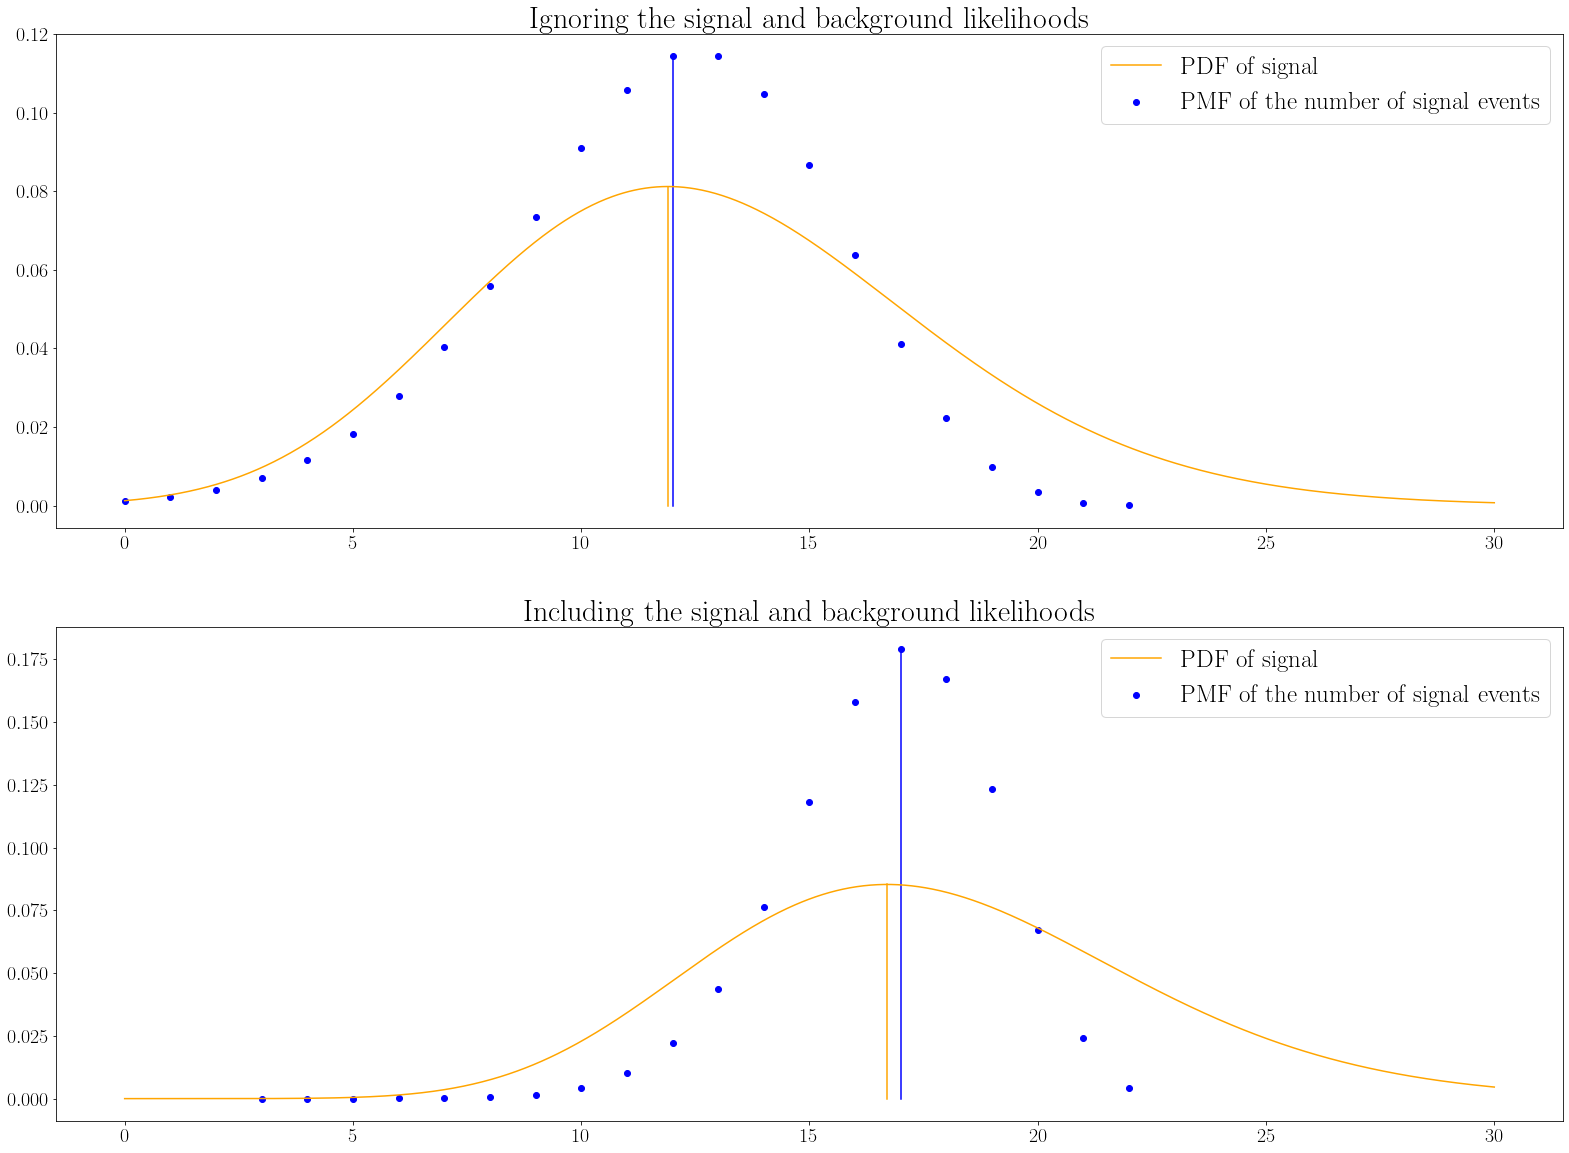

In [78]:
fig, axs = plt.subplots(figsize=(27,20),nrows=2, ncols=1)

ax_ind = 0
# PLOT PMF
axs[ax_ind].scatter( m1.Ns, m1.pmf, label = "PMF of the number of signal events", c="blue")
axs[ax_ind].plot( (m1.mode_pmf,m1.mode_pmf), (0,m1.pmf[m1.Ns==m1.mode_pmf][0]), c="blue")
# PLOT PDF
s = np.linspace(0,30,1000)
axs[ax_ind].plot( s, m1.pdf(s), label = "PDF of signal", c="orange" )
axs[ax_ind].plot( (m1.mode_pdf,m1.mode_pdf), (0,m1.pdf(m1.mode_pdf)), c="orange")
axs[ax_ind].set_title("Ignoring the signal and background likelihoods")
axs[ax_ind].legend()

ax_ind = 1
# PLOT PMF
axs[ax_ind].scatter( m2.Ns, m2.pmf, label = "PMF of the number of signal events", c="blue")
axs[ax_ind].plot( (m2.mode_pmf,m2.mode_pmf), (0,m2.pmf[m2.Ns==m2.mode_pmf][0]), c="blue")
# PLOT PDF
s = np.linspace(0,30,1000)
axs[ax_ind].plot( s, m2.pdf(s), label = "PDF of signal", c="orange" )
axs[ax_ind].plot( (m2.mode_pdf,m2.mode_pdf), (0,m2.pdf(m2.mode_pdf)), c="orange")
axs[ax_ind].set_title("Including the signal and background likelihoods")
axs[ax_ind].legend()

# The Class `PDF`

Another important Class of the module `basilpy` is the `PDF` 

We have already encountered this class previously.

Its main goal is to provide a **PDF** from a custom function which must be defined positive in agivne range. The Class will take care of normalize it

Sometime we might not have access to the analytical form of the *PDF* but only to some already vavailable data there were sampled from the unknown *PDF*. 

In those cases we can use the function `PDF.from_data()`  which will compute the *PDF* from the histogram distribution of the data assuming some custom binning 

Let's see an example

Imagine we know the **PDF** to be proportional to the following function

in which the data are between 0 and 1 (this is the default assumption)

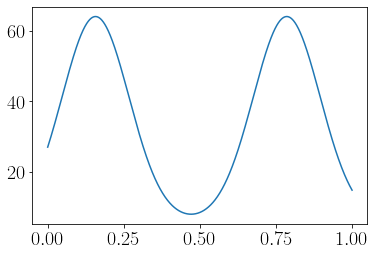

In [312]:
x = np.linspace(0,1,1000)
f = lambda x: (np.sin(x*10)+3)**3
plt.plot(x, f(x) )

Notice that the function is not normalized to 1. This is not a problem

From this function we can now create a `PDF` object and use `PDF.fake()` for simulating data according to such a pdf

You can see how the simulated data follows the distribution we have defined

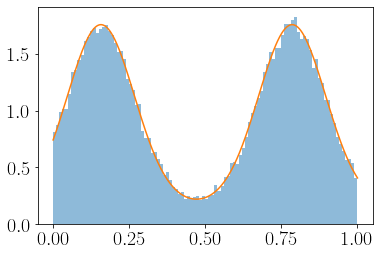

In [315]:
pdf  = bs.PDF(f)
#
data = pdf.fake(50000)
plt.hist(data, alpha=0.5, density=True,bins=100)

x = np.linspace(0,1,1000)
plt.plot(x, pdf(x) )

We can now assume that we do not know the shape of the **PDF* but that we have just sampled from it 500 data `observed_data`

Text(0.5, 0, 'observed data')

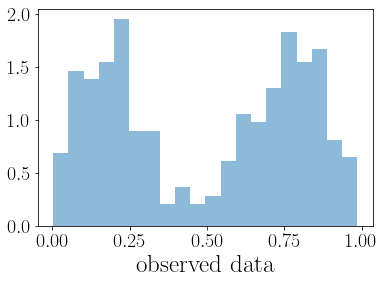

In [322]:
observed_data = pdf.fake(500)
plt.hist(observed_data,alpha=0.5, density=True,bins=20)
plt.xlabel('observed data')

We can now use the `observed_data` to construct a `PDF`

In [329]:
pdf = bs.PDF.from_data(observed_data,bins=20)

AttributeError: type object 'PDF' has no attribute 'from_data'

As done before, we can plot again the **PDF** with some simulated data from it

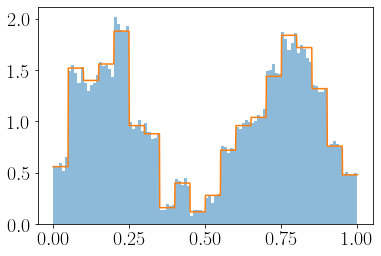

In [327]:
data = pdf.fake(50000)
plt.hist(data, alpha=0.5, density=True,bins=100)

x = np.linspace(0,1,1000)
plt.plot(x, pdf(x) )

... to be continued

# ON/OFF simulations

In [302]:
mf = bs.fake_measurement(s=12.3, b=120, alpha=0.3, bkg_pdf=bkg_pdf, signal_pdf=signal_pdf,seed=4)
mf.run()
print(mf)

OnOffMeasurement
----------------

  Non                             :  76 
  Noff                            :  123 
  Alpha                           :  0.3 

  Excess                          :  39.1 
  SD Excess                       :  9.331130692472376 
  Li&Ma Significance              :  4.77057045020748 

  Most probable signal            :  28.29952727839083 
  Expected signal                 :  29.495822147450653 
  Signal SD                       :  5.431005629480663 



In [25]:
print(mf)

OnOffMeasurement
----------------

  Non                             :  76 
  Noff                            :  123 
  Alpha                           :  0.3 

  Excess                          :  39.1 
  SD Excess                       :  9.331130692472376 
  Li&Ma Significance              :  4.77057045020748 

  Most probable signal            :  26.79502135314373 
  Expected signal                 :  27.739390616222067 
  Signal SD                       :  5.266819782014766 

